In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from toolz import frequencies, sliding_window
from sklearn.linear_model import LinearRegression
from aging.behavior.syllables import relabel_by_usage, assign_onsets
from aging.plotting import format_plots, PlotConfig, save_factory, figure

In [2]:
version = 4
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "age-manifold", tight_layout=False)

In [3]:
def age_map(string) -> int:
    '''returns age in weeks'''
    if '3m' in string:
        return 3 * 4
    if '6m' in string:
        return 6 * 4
    if '12m' in string:
        return 12 * 4
    if '18m' in string:
        return 18 * 4
    if '22m' in string:
        return 22 * 4
    if '3w' in string:
        return 3
    if '5w' in string:
        return 5
    if '7w' in string:
        return 7
    if '9w' in string:
        return 9

## Fit regression to ontogeny

In [4]:
def load_ontogeny():
    df = pd.read_parquet(
        f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_syllable_df_v00.parquet"
    )
    df, usage_map = relabel_by_usage(df)
    df["age"] = df["age"].map(age_map)

    usage_df = (
        df.query("onsets")
        .groupby(["age", "subject_name", "uuid"])["relabeled_syllables"]
        .value_counts(normalize=True)
    )
    usage_df.name = "usage"
    usage_df = usage_df.reset_index()

    usage_mtx = usage_df.pivot_table(
        values="usage", columns="relabeled_syllables", index=["age", "uuid"]
    ).fillna(0)
    return usage_mtx, usage_map

In [5]:
usage_mtx, usage_map = load_ontogeny()

In [6]:
reg = LinearRegression()

In [7]:
reg.fit(usage_mtx.index.get_level_values('age').to_numpy()[:, None], usage_mtx)

LinearRegression()

In [8]:
reg.coef_.shape

(56, 1)

In [9]:
earliest_mouse_age = 21  # days


def age(s):
    return ((s - s.min()).dt.days + earliest_mouse_age) / 7


def load_long_df(new_cols, usage_map, version=4, df_version=0):
    df = pd.read_parquet(
        f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longtogeny_males_syllable_df_v{df_version:02d}.parquet"
    )
    df = assign_onsets(df)
    df["relabeled_syllables"] = df["syllables"].map(usage_map)
    # df = relabel_by_usage(df, return_map=False)
    df["mouse_id"] = df["subject_name"].str[:5]
    df = df[~df["mouse_id"].str.lower().str.contains("c")]
    df = df[~df["mouse_id"].str.lower().str.contains("long")]
    df['age'] = df.groupby("mouse_id", sort=False)['date'].transform(age)

    session_length = df.groupby("uuid")["timestamps"].max()
    remove_uuids = session_length[session_length < 600].index
    df = df[~df["uuid"].isin(remove_uuids)]

    usage_df = (
        df.query("onsets")
        .groupby(["age", "mouse_id", "uuid"])["relabeled_syllables"]
        .value_counts(normalize=True)
    )
    usage_df.name = "usage"
    usage_df = usage_df.reset_index()
    usage_mtx = usage_df.pivot_table(
        values="usage", columns="relabeled_syllables", index=["age", "mouse_id", "uuid"]
    ).reindex(columns=new_cols).fillna(0)

    # remove sessions with abnormally high syllable usage
    usage_mtx = usage_mtx[~(usage_mtx > 0.15).any(axis=1)]

    # remove sessions with abnormally few syllables used
    usage_mtx= usage_mtx[(usage_mtx > 0).sum(axis=1) > 20]
    return usage_mtx.drop('05_02', level=1)

In [10]:
df = load_long_df(usage_mtx.columns, usage_map)

In [13]:
new_df = reg.predict(df.index.get_level_values('age').to_numpy()[:, None])

In [14]:
new_df.shape

(857, 56)

In [15]:
df.shape

(857, 56)

In [16]:
partial_df = df - new_df

In [18]:
partial_df.head()

relabeled_syllables                                      0         1   \
age mouse_id uuid                                                       
3.0 01_01    2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 -0.035867 -0.018093   
             e3e86c43-3f2a-4ace-8734-9e08a9b1ab1f -0.033688 -0.021151   
    01_02    181340b6-6c1d-4528-8920-2102d75d5711 -0.028755 -0.016667   
             a74c80f5-1665-42e8-8975-6e2dd26eba6a -0.025295 -0.018357   
    01_03    3d76f34c-f15b-408a-a014-3c79382a3efe -0.028432 -0.018739   

relabeled_syllables                                      2         3   \
age mouse_id uuid                                                       
3.0 01_01    2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 -0.017676 -0.011438   
             e3e86c43-3f2a-4ace-8734-9e08a9b1ab1f -0.020214 -0.011697   
    01_02    181340b6-6c1d-4528-8920-2102d75d5711 -0.017099 -0.004773   
             a74c80f5-1665-42e8-8975-6e2dd26eba6a -0.019259 -0.017260   
    01_03    3d76f34c-f15b-408a-a014-3c79382a3efe -0.018679 -0.014887   

relabeled_syllables                                      4         5   \
age mouse_id uuid                                                       
3.0 01_01    2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 -0.000802  0.001823   
             e3e86c43-3f2a-4ace-8734-9e08a9b1ab1f  0.000540 -0.009330   
    01_02    181340b6-6c1d-4528-8920-2102d75d5711  0.003855 -0.010352   
             a74c80f5-1665-42e8-8975-6e2dd26eba6a  0.005075  0.000856   
    01_03    3d76f34c-f15b-408a-a014-3c79382a3efe -0.016811 -0.007604   

relabeled_syllables                                      6         7   \
age mouse_id uuid                                                       
3.0 01_01    2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 -0.022549 -0.003731   
             e3e86c43-3f2a-4ace-8734-9e08a9b1ab1f -0.018831 -0.005288   
    01_02    181340b6-6c1d-4528-8920-2102d75d5711 -0.019896  0.013887   
             a74c80f5-1665-42e8-8975-6e2dd26eba6a -0.024853  0.000545   
    01_03    3d76f34c-f15b-408a-a014-3c79382a3efe -0.013822 -0.006561   

relabeled_syllables                                      8         9   ...  \
age mouse_id uuid                                                      ...   
3.0 01_01    2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 -0.007596 -0.008151  ...   
             e3e86c43-3f2a-4ace-8734-9e08a9b1ab1f -0.006496 -0.009149  ...   
    01_02    181340b6-6c1d-4528-8920-2102d75d5711  0.007979 -0.001679  ...   
             a74c80f5-1665-42e8-8975-6e2dd26eba6a -0.003620 -0.015257  ...   
    01_03    3d76f34c-f15b-408a-a014-3c79382a3efe  0.000458 -0.002089  ...   

relabeled_syllables                                      46        47  \
age mouse_id uuid                                                       
3.0 01_01    2c031642-6e7a-4b1a-8b0c-eaa2f28ef089  0.017558 -0.004814   
             e3e86c43-3f2a-4ace-8734-9e08a9b1ab1f  0.015621 -0.004814   
    01_02    181340b6-6c1d-4528-8920-2102d75d5711  0.002120 -0.004343   
             a74c80f5-1665-42e8-8975-6e2dd26eba6a  0.000109 -0.004145   
    01_03    3d76f34c-f15b-408a-a014-3c79382a3efe  0.001920 -0.004814   

relabeled_syllables                                      48        49  \
age mouse_id uuid                                                       
3.0 01_01    2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 -0.004802  0.011741   
             e3e86c43-3f2a-4ace-8734-9e08a9b1ab1f -0.004802  0.016820   
    01_02    181340b6-6c1d-4528-8920-2102d75d5711 -0.004802 -0.004692   
             a74c80f5-1665-42e8-8975-6e2dd26eba6a -0.004134  0.045217   
    01_03    3d76f34c-f15b-408a-a014-3c79382a3efe -0.004802  0.015604   

relabeled_syllables                                      50        51  \
age mouse_id uuid                                                       
3.0 01_01    2c031642-6e7a-4b1a-8b0c-eaa2f28ef089  0.003658 -0.004473   
             e3e86c43-3f2a-4ace-8734-9e08a9b1ab1f  0.000041 -0.004013   
    01_02    181340b6-6c1d-4528-8920-2102d75d5711  0.011048 -0.003061   
             a74

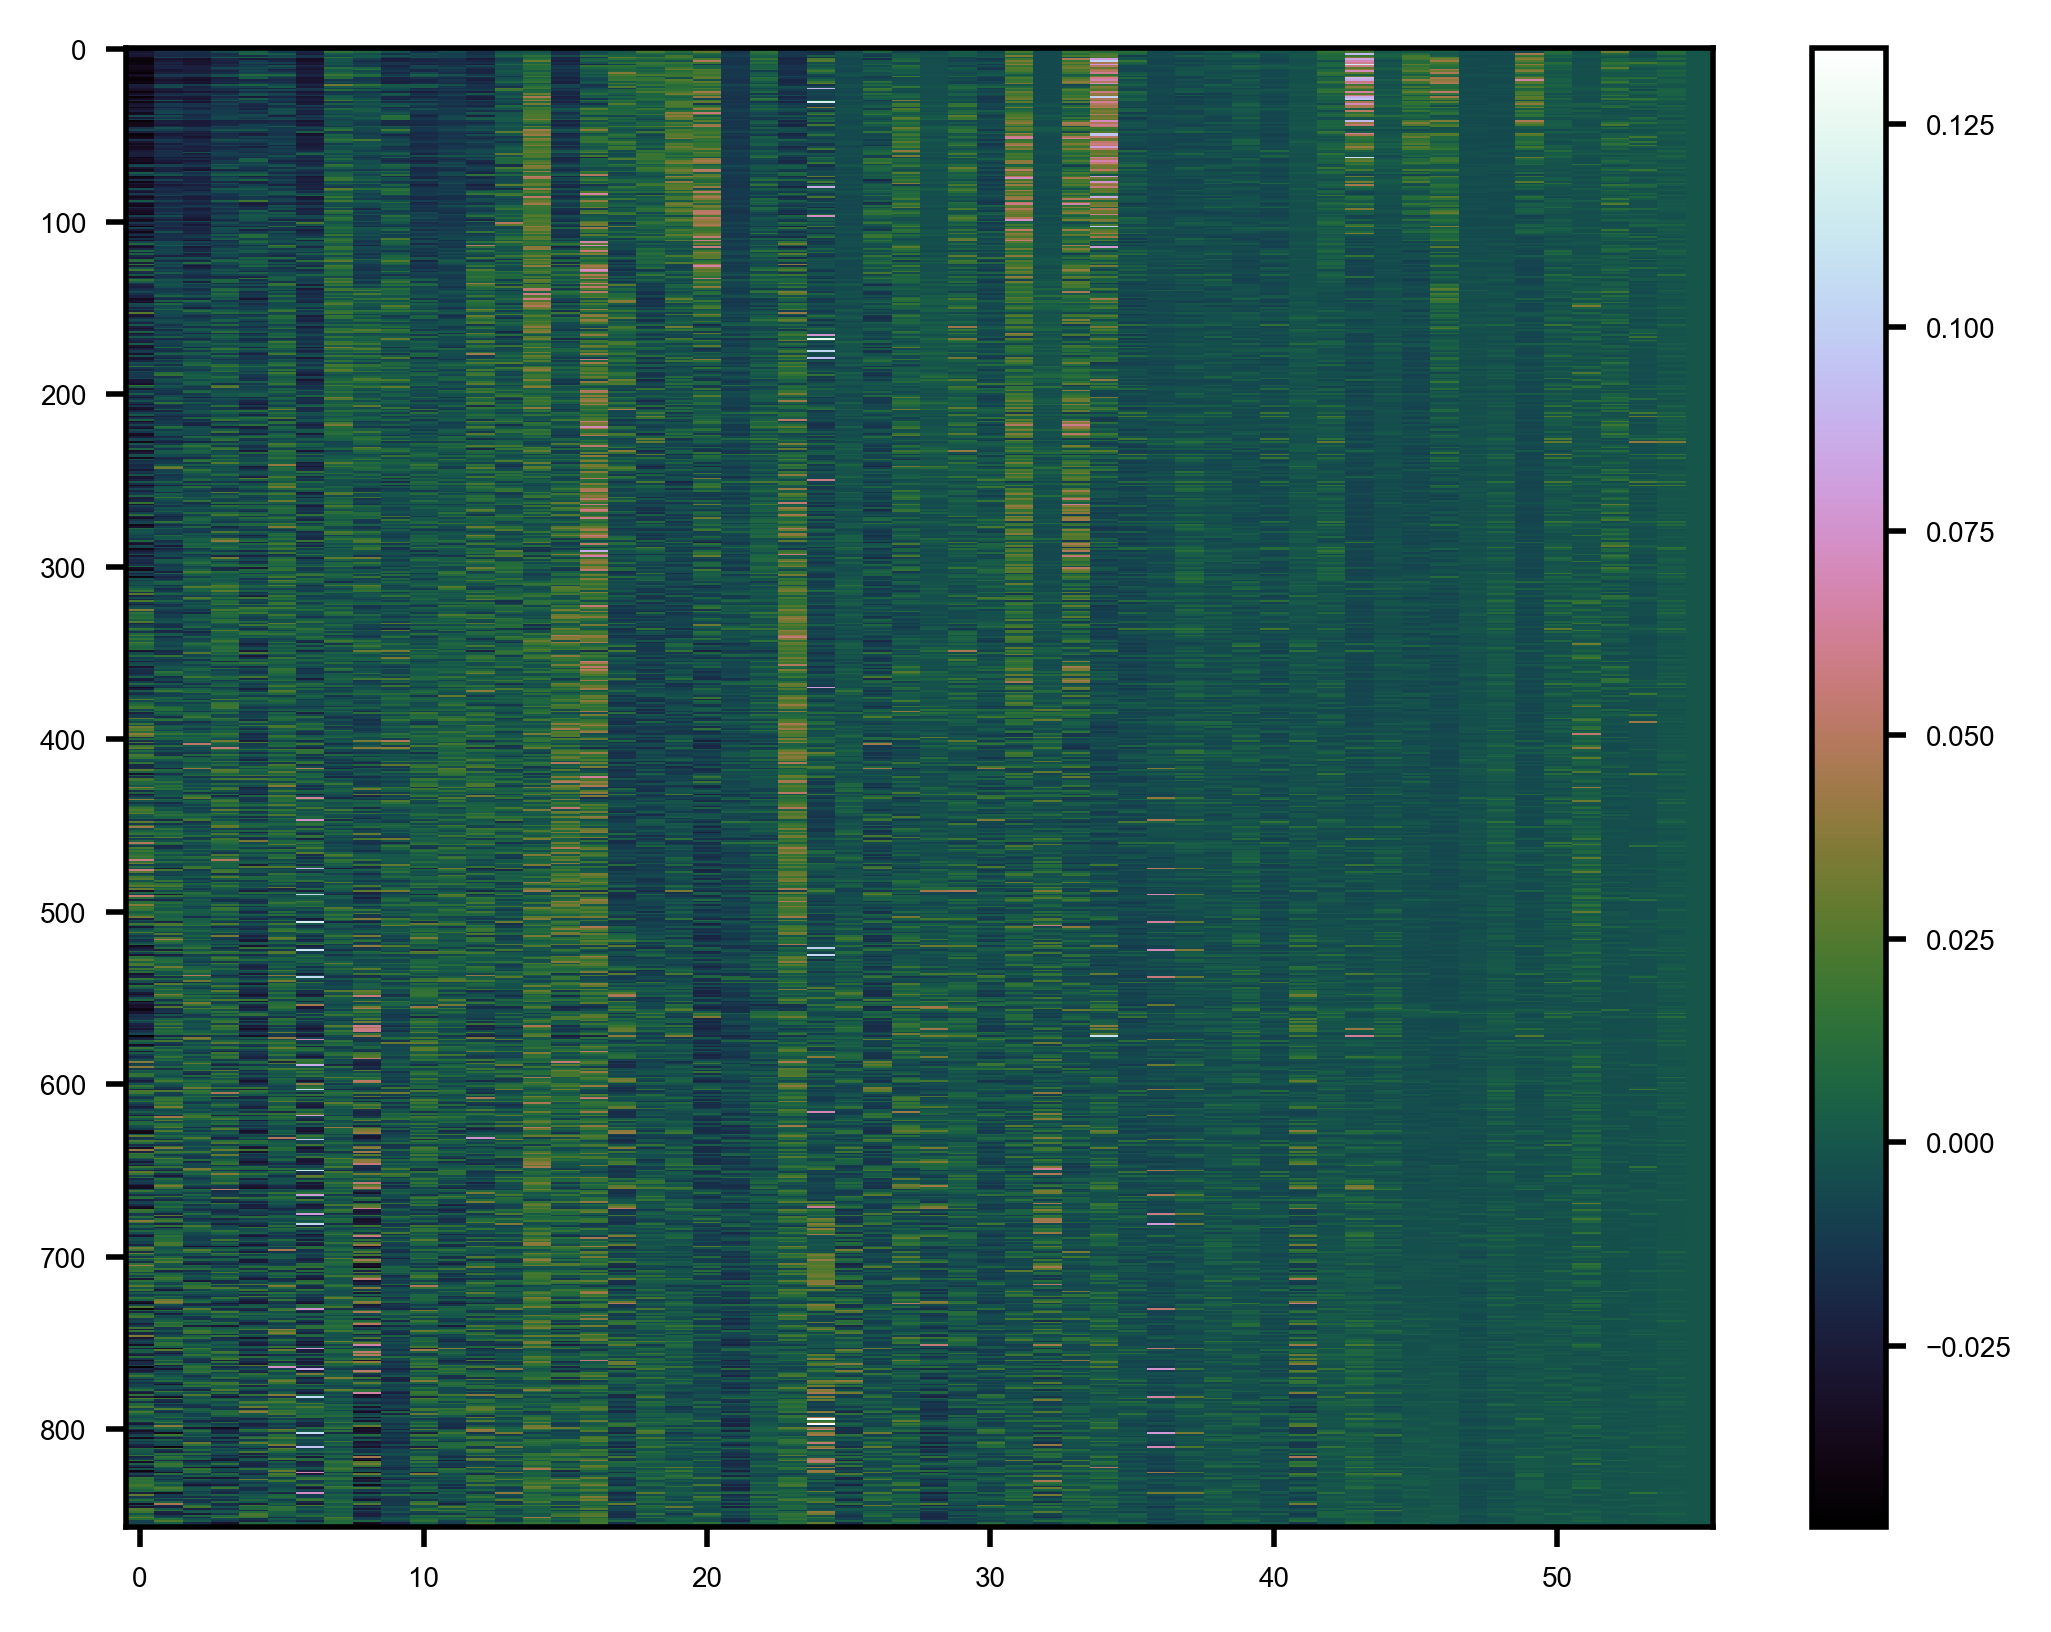

In [21]:
plt.imshow(partial_df, cmap='cubehelix', aspect='auto', interpolation='none')
plt.colorbar()

In [34]:
import colorcet as cc
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [23]:
out = PCA(n_components=2).fit_transform(partial_df)

In [27]:
lbl = LabelEncoder().fit_transform(partial_df.index.get_level_values('mouse_id'))

In [39]:
age = partial_df.index.get_level_values('age')

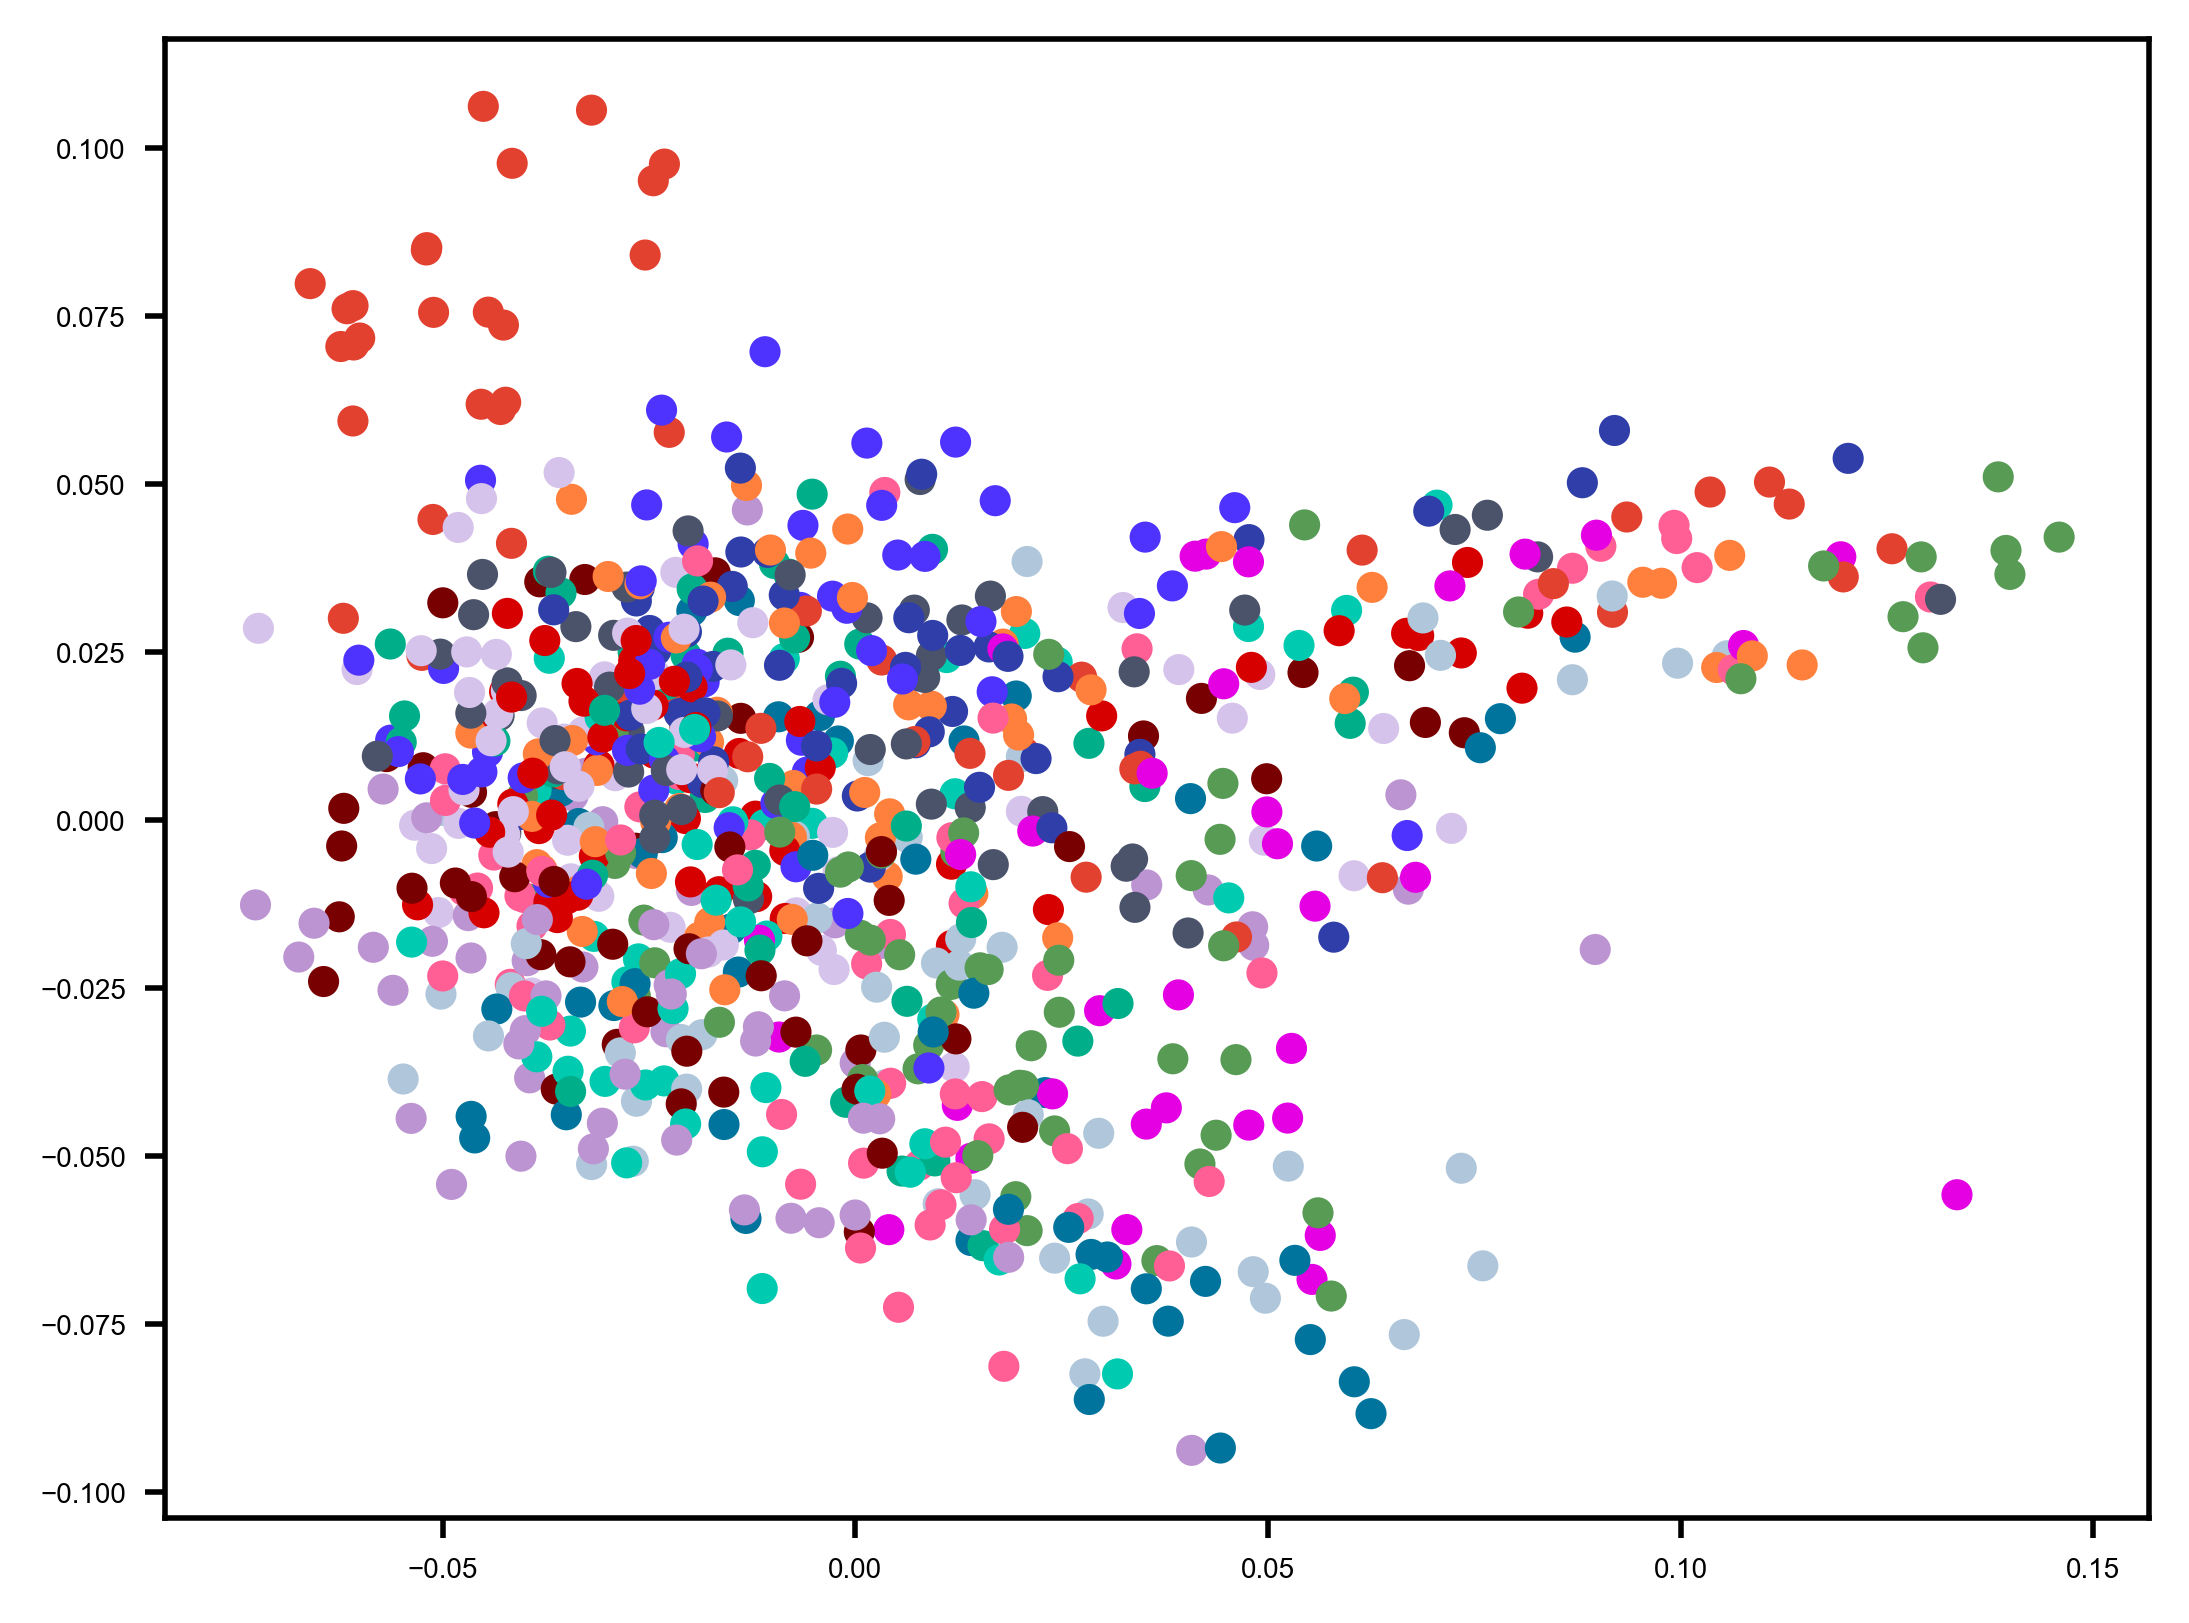

In [35]:
plt.scatter(*out.T, c=lbl, cmap=cc.cm.glasbey)

In [30]:
import umap

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/umap/distanc

In [37]:
mdl = umap.UMAP(n_neighbors=30)
emb = mdl.fit_transform(partial_df)

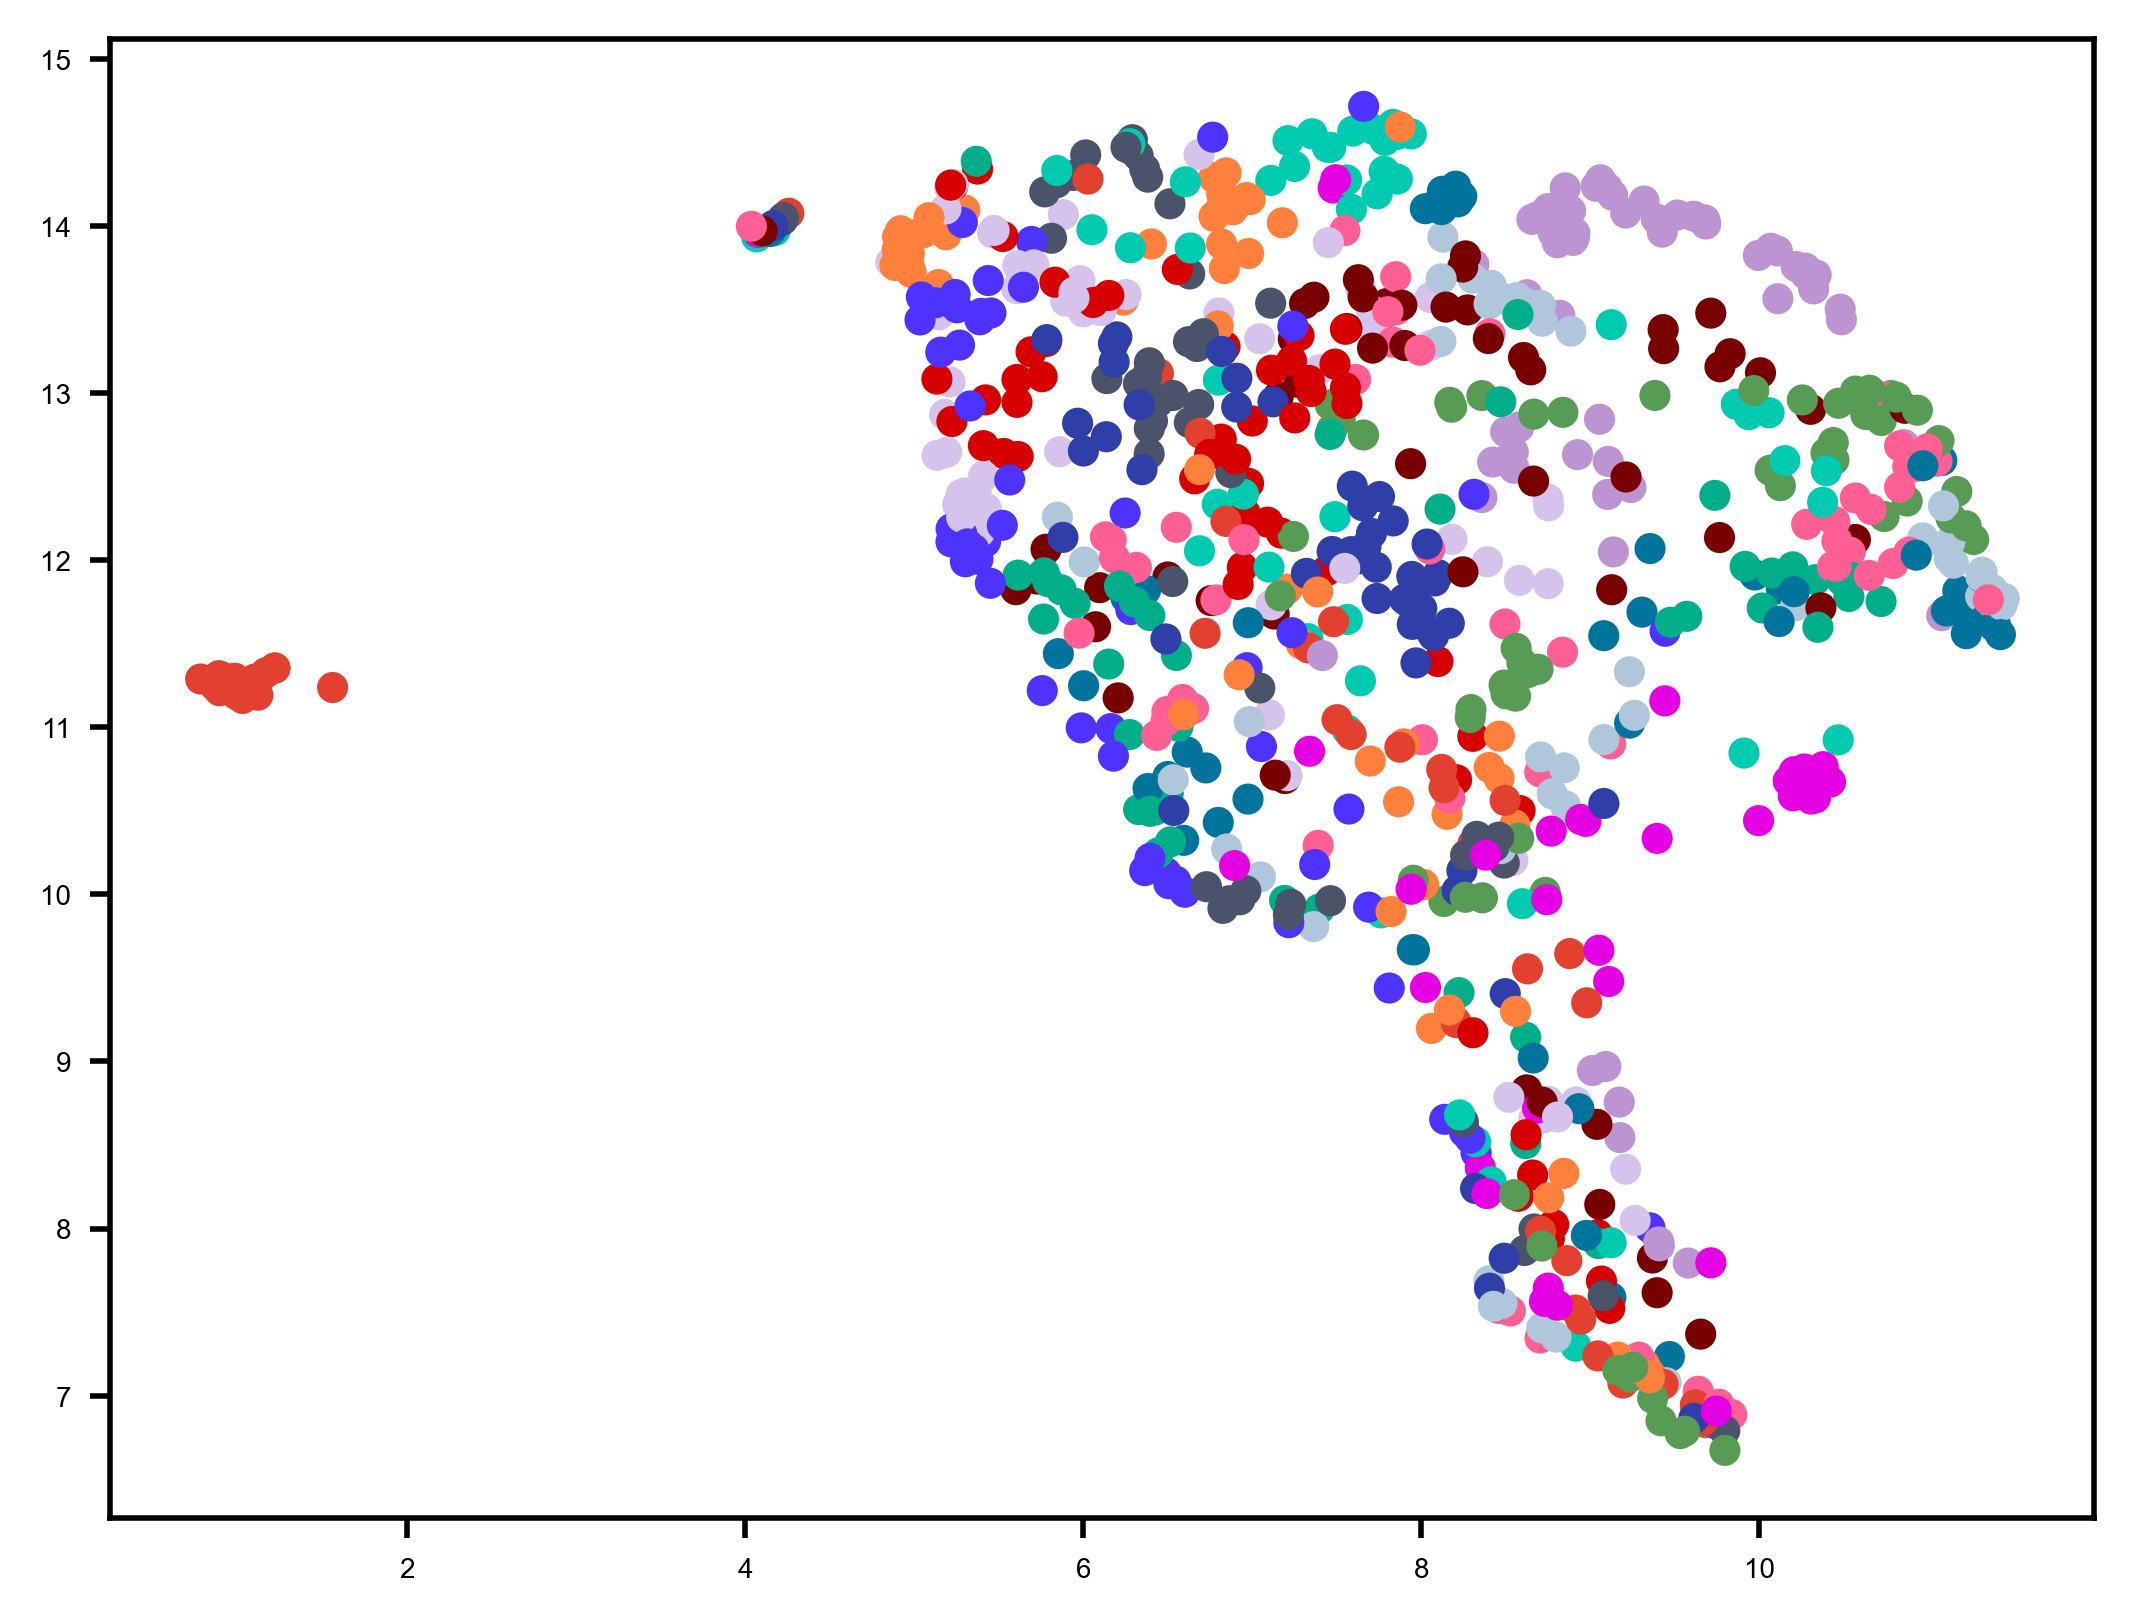

In [38]:
plt.scatter(*emb.T, c=lbl, cmap=cc.cm.glasbey)

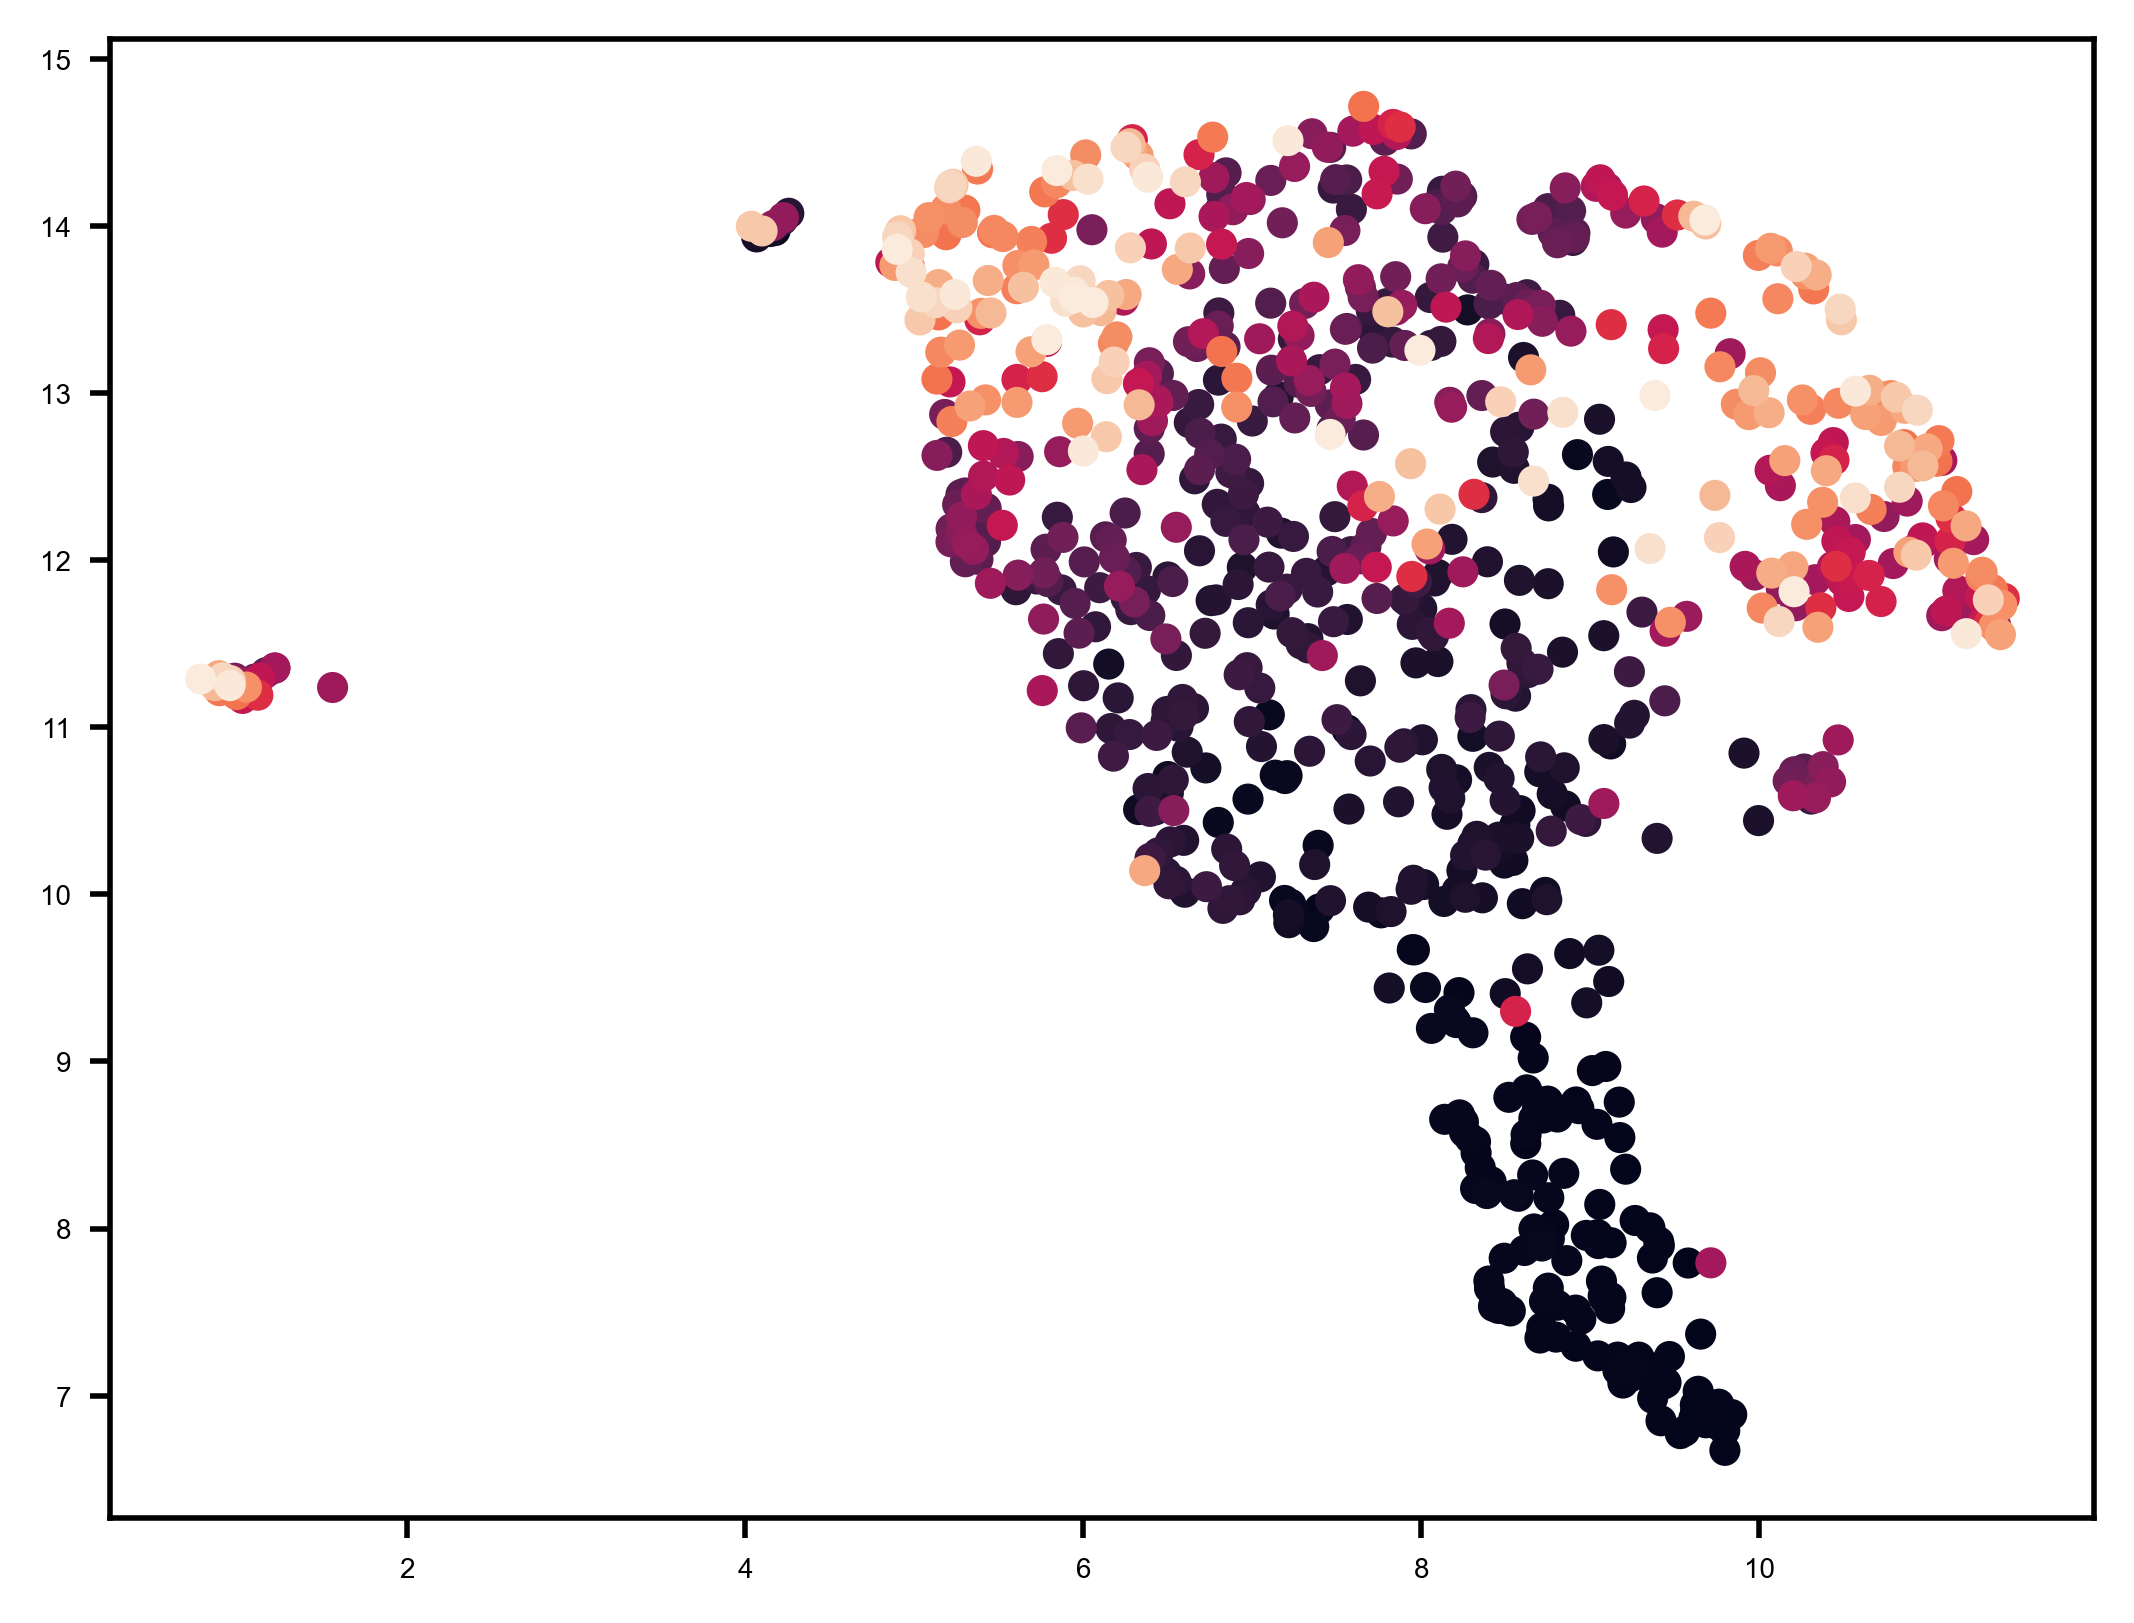

In [40]:
plt.scatter(*emb.T, c=age)